In [8]:
import json
import gzip
import math
from collections import defaultdict
import numpy
from sklearn import linear_model

In [9]:
# This will suppress any warnings, comment out if you'd like to preserve them
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Check formatting of submissions
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

In [11]:
answers = {}

In [12]:
f = open("spoilers.json.gz", 'r')
#f = gzip.open("spoilers.json.gz", 'r')

In [13]:
dataset = []
for l in f:
    d = eval(l)
    dataset.append(d)

In [14]:
f.close()

In [15]:
# A few utility data structures
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

userPerItem = defaultdict(set)
ItemPerUser = defaultdict(set)
users = set()
items = set()

for d in dataset:
    u,i,r = d['user_id'],d['book_id'],d['rating']
    reviewsPerUser[u].append(d)
    reviewsPerItem[i].append(d)
    userPerItem[i].add(u)
    ItemPerUser[u].add(i)
    users.add(u)
    items.add(i)

# Sort reviews per user by timestamp
for u in reviewsPerUser:
    reviewsPerUser[u].sort(key=lambda x: x['timestamp'])

# Same for reviews per item
for i in reviewsPerItem:
    reviewsPerItem[i].sort(key=lambda x: x['timestamp'])

In [16]:
# E.g. reviews for this user are sorted from earliest to most recent
[d['timestamp'] for d in reviewsPerUser['b0d7e561ca59e313b728dc30a5b1862e']]

['2012-03-13',
 '2013-05-06',
 '2013-09-03',
 '2015-04-05',
 '2016-02-10',
 '2016-05-29']

In [17]:
### 1a

In [18]:
def MSE(Y,Y_pred):
    mse = numpy.square(numpy.subtract(numpy.array(Y),numpy.array(Y_pred))).mean()
    return mse

In [19]:
print(len(reviewsPerUser['b0d7e561ca59e313b728dc30a5b1862e']))

6


In [20]:
y = []
y_pred = []

In [21]:
for u in reviewsPerUser.keys():
    if len(reviewsPerUser[u]) <= 1: continue
    sum_rating = []
    d = reviewsPerUser[u][-1]
    r = int(d['rating'])
    y.append(r)
    for i in range(2,len(reviewsPerUser[u])+1):
        d = reviewsPerUser[u][-i]
        r = int(d['rating'])
        sum_rating.append(r)
    y_pred.append(numpy.mean(sum_rating))

In [22]:
answers['Q1a'] = MSE(y,y_pred)

In [23]:
assertFloat(answers['Q1a'])

In [24]:
y = []
y_pred = []

In [25]:
for i in reviewsPerItem.keys():
    if len(reviewsPerItem[i]) <= 1: continue
    sum_rating = []
    d = reviewsPerItem[i][-1]
    r = int(d['rating'])
    y.append(r)
    for j in range(2,len(reviewsPerItem[i])+1):
        d = reviewsPerItem[i][-j]
        r = int(d['rating'])
        sum_rating.append(r)
    y_pred.append(numpy.mean(sum_rating))

In [26]:
answers['Q1b'] = MSE(y,y_pred)

In [27]:
assertFloat(answers['Q1b'])

In [28]:
### 2

In [29]:
answers['Q2'] = []
for N in [1,2,3]:
  y = []
  y_pred = []
  for u in reviewsPerUser.keys():
    if len(reviewsPerUser[u]) <= 1: continue
    sum_rating = []
    d = reviewsPerUser[u][-1]
    r = int(d['rating'])
    y.append(r)
    for i in range(2,len(reviewsPerUser[u])+1):
        d = reviewsPerUser[u][-i]
        r = int(d['rating'])
        sum_rating.append(r)
        if  len(sum_rating) == N:
           #sum_rating.remove(sum_rating[0])
           break
    y_pred.append(numpy.mean(sum_rating))
  answers['Q2'].append(MSE(y,y_pred))

In [30]:
assertFloatList(answers['Q2'], 3)

In [31]:
### 3a

In [32]:
def feature3(N, u): # For a user u and a window size of N
    sum_rating = []
    sum_rating.append(1)
    for i in range(2,len(reviewsPerUser[u])+1):
        #print(i)
        d = reviewsPerUser[u][-i]
        r = int(d['rating'])
        sum_rating.append(r)
        if len(sum_rating) == N+1:
           break
    return sum_rating

In [33]:
answers['Q3a'] = [feature3(2,dataset[0]['user_id']), feature3(3,dataset[0]['user_id'])]

In [34]:
assert len(answers['Q3a']) == 2
assert len(answers['Q3a'][0]) == 3
assert len(answers['Q3a'][1]) == 4

In [35]:
len(answers['Q3a'][0])

3

In [36]:
### 3b

In [37]:
answers['Q3b'] = []
for N in [1,2,3]:
    Y = []
    X = []
    for u in reviewsPerUser.keys():
        if len(reviewsPerUser[u]) <= N+1: continue
        Y.append(reviewsPerUser[u][-1]['rating'])
        X.append(feature3(N,u))
    X = numpy.matrix(X)
    Y = numpy.matrix(Y).T
    model = linear_model.LinearRegression(fit_intercept=False)
    model.fit(X, Y)
    theta = model.coef_
    Y_pred = model.predict(X)
    mse = MSE(Y,Y_pred)
    answers['Q3b'].append(mse)

In [38]:
assertFloatList(answers['Q3b'], 3)

In [39]:
### 4a

In [40]:
globalAverage = [d['rating'] for d in dataset]
globalAverage = sum(globalAverage) / len(globalAverage)

In [41]:
def featureMeanValue(N, u): # For a user u and a window size of N
    sum_rating = []
    sum_rating.append(1)
    sum = 0
    for i in range(2,N+2):
        #print(i)
      if i <= len(reviewsPerUser[u]):
        d = reviewsPerUser[u][-i]
        r = int(d['rating'])
        sum_rating.append(r)
        sum += r
      else:
        sum_rating.append(sum/(len(reviewsPerUser[u])-1))
    return sum_rating

In [42]:
def featureMissingValue(N, u):
    sum_rating = []
    sum_rating.append(1)
    for i in range(2,N+2):
      if i <= len(reviewsPerUser[u]):
        d = reviewsPerUser[u][-i]
        r = int(d['rating'])
        sum_rating.append(0)
        sum_rating.append(r)
      else:
        sum_rating.append(1)
        sum_rating.append(0)
    return sum_rating

In [43]:
answers['Q4a'] = [featureMeanValue(10, dataset[0]['user_id']), featureMissingValue(10, dataset[0]['user_id'])]

In [44]:
assert len(answers['Q4a']) == 2
assert len(answers['Q4a'][0]) == 11
assert len(answers['Q4a'][1]) == 21

In [45]:
### 4b

In [46]:
answers['Q4b'] = []
for featFunc in [featureMeanValue, featureMissingValue]:
    Y = []
    X = []
    for u in reviewsPerUser.keys():
       if len(reviewsPerUser[u]) <= 1: continue
       Y.append(reviewsPerUser[u][-1]['rating'])
       X.append(featFunc(10,u))
    X = numpy.matrix(X)
    Y = numpy.matrix(Y).T
    model = linear_model.LinearRegression(fit_intercept=False)
    model.fit(X, Y)
    theta = model.coef_
    Y_pred = model.predict(X)
    mse = MSE(Y,Y_pred)
    answers['Q4b'].append(mse)

In [47]:
assertFloatList(answers["Q4b"], 2)

In [48]:
### 5

In [49]:
def feature5(sentence):
    feature = []
    feature.append(1)
    feature.append(len(sentence))
    fea1 = 0
    fea2 = 0
    for ch in sentence:
        if ch == '!': fea1 += 1
        if ch.isupper(): fea2 += 1
    feature.append(fea1)
    feature.append(fea2)
    return feature

In [50]:
Y = []
X = []

for d in dataset:
    for spoiler,sentence in d['review_sentences']:
        X.append(feature5(sentence))
        Y.append(spoiler)

In [51]:
# Logistic regression classifier
clf = linear_model.LogisticRegression(C=1, class_weight='balanced')
clf.fit(X, Y)
print(clf.coef_)
print(clf.classes_)
pred = clf.predict(X)
theta = numpy.matrix(clf.coef_)

[[-0.10011676  0.00121171  0.05295309  0.03518246]]
[0 1]


In [52]:
answers['Q5a'] = X[0]

In [53]:
# True positives, false positives, etc.
TP_ = numpy.logical_and(pred, Y)
TP = sum(TP_)
print('TP = ', TP)

FP_ = numpy.logical_and(pred, numpy.logical_not(Y))
FP = sum(FP_)
print('FP = ', FP)

TN_ = numpy.logical_and(numpy.logical_not(pred), numpy.logical_not(Y))
TN = sum(TN_)
print('TN = ', TN)

FN_ = numpy.logical_and(numpy.logical_not(pred), Y)
FN = sum(FN_)
print('FN = ', FN)

# accuracy sum(correct) / len(correct)
accuracy = (TP + TN) / (TP + FP + TN + FN)
print('ACC = ', accuracy)
# BER
BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
print('BER = ', BER)

TP =  2384
FP =  86232
TN =  168945
FN =  3615
ACC =  0.6559905963794529
BER =  0.4702652880062319


In [54]:
answers['Q5b'] = [TP, TN, FP, FN, BER]

In [55]:
assert len(answers['Q5a']) == 4
assertFloatList(answers['Q5b'], 5)

In [56]:
### 6

In [57]:
def feature6(review):
    feature = []
    for i in range(6):
        spoiler,sentence = review['review_sentences'][i]
        if i != 5:
            feature.append(spoiler)
        else:
            feature += feature5(sentence)
    return feature

In [58]:
Y = []
X = []

for d in dataset:
    sentences = d['review_sentences']
    if len(sentences) < 6: continue
    X.append(feature6(d))
    Y.append(sentences[5][0])

#etc.

In [59]:
# Logistic regression classifier
clf = linear_model.LogisticRegression(C=1, class_weight='balanced')
clf.fit(X, Y)
print(clf.coef_)
print(clf.classes_)
pred = clf.predict(X)
theta = numpy.matrix(clf.coef_)

[[-0.29264875  1.2723029   0.10869029  2.30166218  5.76080724 -0.93231298
   0.00715562  0.48517314  0.07792321]]
[0 1]


In [60]:
# True positives, false positives, etc.
TP_ = numpy.logical_and(pred, Y)
TP = sum(TP_)
print('TP = ', TP)

FP_ = numpy.logical_and(pred, numpy.logical_not(Y))
FP = sum(FP_)
print('FP = ', FP)

TN_ = numpy.logical_and(numpy.logical_not(pred), numpy.logical_not(Y))
TN = sum(TN_)
print('TN = ', TN)

FN_ = numpy.logical_and(numpy.logical_not(pred), Y)
FN = sum(FN_)
print('FN = ', FN)

# accuracy sum(correct) / len(correct)
accuracy = (TP + TN) / (TP + FP + TN + FN)
print('ACC = ', accuracy)
# BER
BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
print('BER = ', BER)

TP =  144
FP =  437
TN =  11263
FN =  63
ACC =  0.958007894515831
BER =  0.170849126718692


In [61]:
answers['Q6a'] = X[0]

In [62]:
answers['Q6b'] = BER

In [63]:
assert len(answers['Q6a']) == 9
assertFloat(answers['Q6b'])

In [64]:
### 7

In [65]:
# 50/25/25% train/valid/test split
Xtrain, Xvalid, Xtest = X[:len(X)//2], X[len(X)//2:(3*len(X))//4], X[(3*len(X))//4:]
Ytrain, Yvalid, Ytest = Y[:len(X)//2], Y[len(X)//2:(3*len(X))//4], Y[(3*len(X))//4:]

In [66]:
def accuracy(predictions, y):
    acc = 0
    for i in range(len(y)):
        if predictions[i] == y[i]:
            acc += 1
    return acc/len(y)

In [67]:
def BER(predictions, y):
    TPi = numpy.logical_and(predictions, y)
    FPi = numpy.logical_and(predictions, numpy.logical_not(y))
    TNi = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(y))
    FNi = numpy.logical_and(numpy.logical_not(predictions), y)

    TP = sum(TPi)
    FP = sum(FPi)
    TN = sum(TNi)
    FN = sum(FNi)
    ber =  1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
    return ber

In [68]:
acc_train = []
acc_test = []
acc_valid = []
ber_train = []
ber_test = []
ber_valid = []
ber_C = {}
C = [0.01, 0.1, 1, 10, 100]

In [69]:
for c in [0.01, 0.1, 1, 10, 100]:
    mod = linear_model.LogisticRegression(C=c, class_weight='balanced')
    mod.fit(Xtrain, Ytrain)
    pred_train = mod.predict(Xtrain)
    pred_valid = mod.predict(Xvalid)
    pred_test = mod.predict(Xtest)
    acc_train.append(accuracy(pred_train,Ytrain))
    acc_test.append(accuracy(pred_test,Ytest))
    acc_valid.append(accuracy(pred_valid,Yvalid))
    ber_train.append(BER(pred_train,Ytrain))
    ber_test.append(BER(pred_test, Ytest))
    ber_valid.append(BER(pred_valid, Yvalid))
    ber_C[BER(pred_valid, Yvalid)]=c

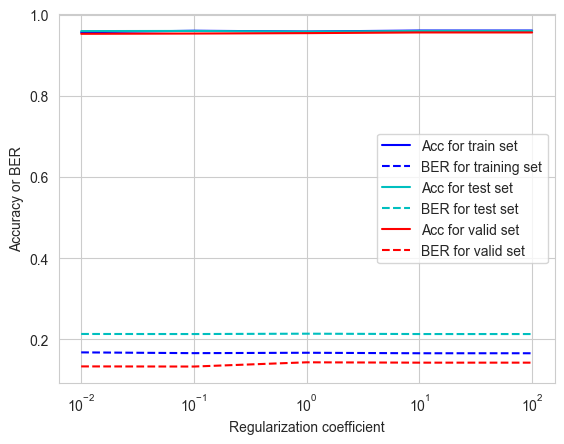

In [70]:
import matplotlib.pyplot as plt

plt.plot(C, acc_train, 'b-', label='Acc for train set')
plt.plot(C, ber_train, 'b--', label='BER for training set')
plt.plot(C, acc_test, 'c-', label='Acc for test set')
plt.plot(C, ber_test, 'c--', label='BER for test set')
plt.plot(C, acc_valid, 'r-', label='Acc for valid set')
plt.plot(C, ber_valid, 'r--', label='BER for valid set')

plt.legend()
plt.xlabel('Regularization coefficient')
plt.xscale('log')
plt.ylabel('Accuracy or BER')
plt.show()

In [71]:
ber_valid.sort()
for ber in ber_valid:
    print(ber_C[ber],ber)
bers = ber_valid
bestC = ber_C[ber_valid[0]]
#index1 -> 0.1
ber = ber_test[1]

0.1 0.13310974685463095
0.01 0.13345081097468547
100 0.14268606942549644
100 0.14268606942549644
1 0.14353872972563286


In [72]:
answers['Q7'] = bers + [bestC] + [ber]

In [73]:
assertFloatList(answers['Q7'], 7)

In [74]:
### 8

In [75]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [76]:
# 75/25% train/test split
dataTrain = dataset[:15000]
dataTest = dataset[15000:]

In [77]:
# A few utilities
itemAverages = defaultdict(list)
usersAverages = defaultdict(list)
ratingMean = []

for d in dataTrain:
    itemAverages[d['book_id']].append(d['rating'])
    usersAverages[d['user_id']].append(d['rating'])
    ratingMean.append(d['rating'])

for i in itemAverages:
    itemAverages[i] = sum(itemAverages[i]) / len(itemAverages[i])

for u in usersAverages:
    usersAverages[u] = sum(usersAverages[u]) / len(usersAverages[u])

ratingMean = sum(ratingMean) / len(ratingMean)

In [78]:
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
timesPerItem = defaultdict(list)
items = set()

for d in dataTrain:
    u,i = d['user_id'], d['book_id']
    reviewsPerUser[u].append(d)
    reviewsPerItem[i].append(d)
    usersPerItem[i].add(u)
    itemsPerUser[u].add(i)
    items.add(i)
    timesPerItem[i].append(int(1))

In [79]:
# From my HW2 solution, welcome to reuse
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['book_id']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        if item in itemAverages:
            return itemAverages[item]
        else:
            return ratingMean


In [81]:
ratings_data = []
ratings_pred = []
for d in dataTest:
    ratings_data.append(d['rating'])
    ratings_pred.append(predictRating(d['user_id'],d['book_id']))
MSE(ratings_pred, ratings_data)

1.816493441279133

In [295]:
answers["Q8"] = MSE(ratings_pred, ratings_data)

In [296]:
assertFloat(answers["Q8"])

In [297]:
### 9

In [298]:
ratings_data0 = []
ratings_pred0 = []
ratings_data1 = []
ratings_pred1 = []
ratings_data2 = []
ratings_pred2 = []

for d in dataTest:
    u,i,r = d['user_id'],d['book_id'],d['rating']
    if i not in items:
        ratings_data0.append(r)
        ratings_pred0.append(predictRating(u,i))
    elif len(timesPerItem[i])<=5:
        ratings_data1.append(r)
        ratings_pred1.append(predictRating(u,i))
    else:
        ratings_data2.append(r)
        ratings_pred2.append(predictRating(u,i))

mse0 = MSE(ratings_pred0, ratings_data0)
mse1to5 = MSE(ratings_pred1, ratings_data1)
mse5 = MSE(ratings_pred2, ratings_data2)

In [299]:
answers["Q9"] = [mse0, mse1to5, mse5]

In [300]:
assertFloatList(answers["Q9"], 3)

In [301]:
### 10

In [302]:
def predictRating_interchange(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerItem[item]:
        v = d['user_id']
        if v != user:
          ratings.append(d['rating'] - usersAverages[v])
          similarities.append(Jaccard(itemsPerUser[user],itemsPerUser[v]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return usersAverages[user] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        # User hasn't rated any similar items
        if user in usersAverages:
            return usersAverages[user]
        return ratingMean

In [303]:
print(mse0)

1.7420124844444445


In [331]:
ratings_data4 = []
ratings_pred4 = []
for d in dataTest:
    u,i,r = d['user_id'],d['book_id'],d['rating']
    if i not in items:
        ratings_data4.append(r)
        ratings_pred4.append(predictRating_interchange(u,i))
itsMSE = MSE(ratings_pred4, ratings_data4)
print(itsMSE)

1.6696633366192306


In [338]:
def feature10(spoiler,sentence):
    feature = []
    feature.append(spoiler)
    feature.append(len(sentence))
    fea1 = 0
    fea2 = 0
    for ch in sentence:
        if ch == '!': fea1 += 1
        if ch.isupper(): fea2 += 1
    feature.append(fea1)
    feature.append(fea2)
    return feature

In [343]:
featurePerItem = defaultdict(list)
for d in dataTrain:
    u,i,r = d['user_id'],d['book_id'],d['rating']
    for spoiler,sentence in d['review_sentences']:
        featurePerItem[i].append(feature10(spoiler,sentence))

#average the features
featureAverage = defaultdict(list)
for i in featurePerItem:
    featureAverage[i] = numpy.mean(featurePerItem[i],axis=0)
    numpy.append(featureAverage[i],len(reviewsPerItem[i]))

In [344]:
def cos_dis(l1,l2):
    inter = 0
    sum = 0
    for i in range(len(l1)):
        sum += l1[i]*l1[i]
        sum += l2[i]*l2[i]
        inter += l1[i]*l2[i]
    return inter/numpy.sqrt(sum)

In [346]:
# features way to do
def predictRating_improve(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['book_id']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        if item in itemAverages:
            return itemAverages[item]
        else:
            #store the distance between the vectors
            cos_distances = []
            item_feature = featureAverage_test[item]
            dis_item = defaultdict()
            for item_train in featureAverage:
                cos_value = cos_dis(featureAverage[item_train],item_feature)
                cos_distances.append(cos_value)
                dis_item[cos_value] = item_train
            #find the closest item_train
            cos_distances.sort()
            item_closests = []
            sample = 20
            for k in range(1,sample+1):
                item_closests.append(dis_item[cos_distances[-k]])
            predict = []
            for item in item_closests:
                predict.append(predictRating_improve(user,item))
            return numpy.mean(predict)

In [352]:
ratings_data5 = []
ratings_pred5 = []
featurePerItem_test = defaultdict(list)
#average the features
featureAverage_test = defaultdict(list)
reviewsPerItem_test = defaultdict(list)
for d in dataTest:
    u,i,r = d['user_id'],d['book_id'],d['rating']
    reviewsPerItem_test[i].append(d)
    for spoiler,sentence in d['review_sentences']:
        featurePerItem_test[i].append(feature10(spoiler,sentence))

for i in featurePerItem_test:
    featureAverage_test[i] = numpy.mean(featurePerItem_test[i],axis=0)
    numpy.append(featureAverage_test[i],len(reviewsPerItem_test[i]))

for d in dataTest:
    u,i,r = d['user_id'],d['book_id'],d['rating']
    if i not in items:
        ratings_data5.append(r)
        ratings_pred5.append(0.4 * ratingMean + 0.6 * predictRating_improve(u,i))
itsMSE2 = MSE(ratings_pred5, ratings_data5)
print(itsMSE2)

1.7291852422284035


In [330]:
ratings_data6 = []
ratings_pred6 = []
for d in dataTest:
    u,i,r = d['user_id'],d['book_id'],d['rating']
    if i not in items:
        ratings_data6.append(r)
        if u in users:
            ratings_pred6.append(0.5 * predictRating_interchange(u,i) + 0.5 * predictRating(u,i))
        else:
           #both user and item are not in here
           ratings_pred6.append(0.6 * ratingMean + 0.4 * predictRating_improve(u,i))
itsMSE3 = MSE(ratings_pred6, ratings_data6)
print(itsMSE3)

1.501864970293575


In [327]:
improvements = \
     "From q9a, mse0 is 1.7420. \
     The item is unseen, but the user who rates the item may be seen. \
     In this situation, we can use information from users. \
     So we modify the similarity function to interchange users and items rating prediction and get the fucntion predictRating_interchange. \
     In this way, we could slightly improve the mse to 1.6697. \
     We can also use weights like 0.5 * predictRating_interchange + 0.5 * predictRating to predict. \
     In this way, we could slightly improve the mse to 1.5019. \
     If the both of the item and user are not seen(the situation not in this dataset) \
     we can find the most similar item or user based on the some features in the review. \
     For example, we can create a feature vector like [length in chars,number of ‘!’,number of capital letters]. \
     Compare the vectors' cos distances between the unseen item and seen items, and choose the most similar one."

In [328]:
answers["Q10"] = (improvements, itsMSE3)

In [440]:
assert type(answers["Q10"][0]) == str
assertFloat(answers["Q10"][1])

In [441]:
f = open("answers_midterm.txt", 'w')
f.write(str(answers) + '\n')
f.close()